<a href="https://colab.research.google.com/github/khaylheb99/KorinAI/blob/main/Audio_Genre_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MELODY GENERATION

In [41]:
!pip install music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [42]:
from music21 import stream, note, scale, tempo, chord
from IPython.display import Audio
import numpy as np

def generate_melody(genre="Afrobeat", duration_sec=30, output_file="output.mid"):
    """Generate genre-specific melody with basic rules"""
    s = stream.Stream()

    # Genre templates
    templates = {
        "Afrobeat": {
            "scale": scale.MinorScale('C4'),
            "tempo": 120,
            "pattern": [1,3,5,6,5,3,1,2,3,5]
        },
        "Fuji": {
            "scale": scale.MixolydianScale('F4'),
            "tempo": 140,
            "pattern": [1,2,3,5,3,2,1,5,4,2]
        },
        "Jazz": {
            "scale": scale.MajorScale('G4'),
            "tempo": 100,
            "pattern": [2,3,5,6,9,7,5,3]
        }
    }

    # Apply template
    params = templates.get(genre, templates["Afrobeat"])
    s.append(tempo.MetronomeMark(number=params["tempo"]))

    # Generate notes with rhythmic variation
    notes = []
    for i in range(int(duration_sec * 2)):  # 2 notes per second
        degree = params["pattern"][i % len(params["pattern"])]
        pitch = params["scale"].pitchFromDegree(degree)
        duration = 0.5 if i % 4 < 2 else 0.25  # Syncopation
        notes.append(note.Note(pitch, quarterLength=duration))

    # Add simple drum backbeat
    drum_part = stream.Part()
    for i in range(int(duration_sec * 2)):
        if i % 4 == 0:  # Kick on downbeat
            drum_part.append(note.Note("C2", quarterLength=0.5))
        elif i % 4 == 2:  # Snare on backbeat
            drum_part.append(note.Note("D2", quarterLength=0.5))

    s.append(notes)
    s.append(drum_part)
    s.write('midi', fp=output_file)

    # Play in Colab
    return Audio(output_file)

# Generate and play
generate_melody("Fuji", 30, "fuji.mid")

## AUDIO GENRE CLASSIFIER

In [43]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andradaolteanu_gtzan_dataset_music_genre_classification_path = kagglehub.dataset_download('andradaolteanu/gtzan-dataset-music-genre-classification')

print('Data source import complete.')


Data source import complete.


In [44]:
audio_dir = os.path.join(andradaolteanu_gtzan_dataset_music_genre_classification_path, 'Data', 'genres_original')

if not os.path.exists(audio_dir):
    raise FileNotFoundError(f"Audio directory not found at {audio_dir}. Check the dataset structure.")

genres = sorted([d for d in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, d))])
print("Available genres:", genres)

Available genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [45]:
!pip install tensorflow_hub
!pip install librosa

In [46]:
import librosa
import numpy as np

def extract_features(file_path, n_mfcc=13, n_chroma=12, n_contrast=4):
    """
    Extract audio features from a file using Librosa
    Returns a dictionary of features
    """
    try:
        y, sr = librosa.load(file_path, duration=30)  # Load first 30 seconds
        features = {}

        # MFCCs (Mel-frequency cepstral coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features['mfcc_mean'] = np.mean(mfcc, axis=1)
        features['mfcc_std'] = np.std(mfcc, axis=1)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_std'] = np.std(chroma, axis=1)

        # Spectral contrast - with safer parameters
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_contrast, fmin=200.0)
        features['contrast_mean'] = np.mean(contrast, axis=1)
        features['contrast_std'] = np.std(contrast, axis=1)

        # Tonnetz (tonal centroid features)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz, axis=1)
        features['tonnetz_std'] = np.std(tonnetz, axis=1)

        # Zero crossing rate
        features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))

        # Spectral centroid
        features['centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

        # Spectral bandwidth
        features['bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

        # Spectral rolloff
        features['rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

        # RMS energy
        features['rms'] = np.mean(librosa.feature.rms(y=y))

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [47]:
import os
import pandas as pd
from tqdm import tqdm

def create_dataset(audio_dir, genres):
    data = []

    for genre in genres:
        genre_dir = os.path.join(audio_dir, genre)
        if not os.path.exists(genre_dir):
            continue

        print(f"Processing {genre} files...")
        for file in tqdm(os.listdir(genre_dir)):
            if file.endswith('.wav') or file.endswith('.mp3'):
                file_path = os.path.join(genre_dir, file)
                features = extract_features(file_path)
                if features:
                    features['genre'] = genre
                    data.append(features)

    return pd.DataFrame(data)

genres = ['hiphop', 'blues', 'jazz']
df = create_dataset(audio_dir, genres=['hiphop', 'blues', 'jazz'])

# Save the features for later use
df.to_csv('/content/audio_features.csv', index=False)

Processing hiphop files...


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


Processing blues files...


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


Processing jazz files...


 26%|██▌       | 26/100 [00:23<01:06,  1.11it/s]<ipython-input-46-77bec5f2f836>:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)  # Load first 30 seconds
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 27/100 [00:23<00:53,  1.35it/s]

Error processing /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


In [48]:
!ls /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues

blues.00000.wav  blues.00020.wav  blues.00040.wav  blues.00060.wav  blues.00080.wav
blues.00001.wav  blues.00021.wav  blues.00041.wav  blues.00061.wav  blues.00081.wav
blues.00002.wav  blues.00022.wav  blues.00042.wav  blues.00062.wav  blues.00082.wav
blues.00003.wav  blues.00023.wav  blues.00043.wav  blues.00063.wav  blues.00083.wav
blues.00004.wav  blues.00024.wav  blues.00044.wav  blues.00064.wav  blues.00084.wav
blues.00005.wav  blues.00025.wav  blues.00045.wav  blues.00065.wav  blues.00085.wav
blues.00006.wav  blues.00026.wav  blues.00046.wav  blues.00066.wav  blues.00086.wav
blues.00007.wav  blues.00027.wav  blues.00047.wav  blues.00067.wav  blues.00087.wav
blues.00008.wav  blues.00028.wav  blues.00048.wav  blues.00068.wav  blues.00088.wav
blues.00009.wav  blues.00029.wav  blues.00049.wav  blues.00069.wav  blues.00089.wav
blues.00010.wav  blues.00030.wav  blues.00050.wav  blues.00070.wav  blues.00090.wav
blues.00011.wav  blues.00031.wav  blues.00051.wav  blues.00071.wav  blues.00

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load your CSV file
df = pd.read_csv('/content/audio_features.csv')  # Update path

# Convert string representations of arrays to numpy arrays
def convert_features(col):
    return np.array([np.fromstring(x[1:-1], sep=' ') for x in col])

# List of array-type features
array_features = [
    'mfcc_mean', 'mfcc_std', 'chroma_mean', 'chroma_std',
    'contrast_mean', 'contrast_std', 'tonnetz_mean', 'tonnetz_std'
]

# Convert these columns
for feature in array_features:
    df[feature] = convert_features(df[feature])

# Create feature matrix by combining all features
X = np.hstack([
    np.vstack(df['mfcc_mean'].values),
    np.vstack(df['mfcc_std'].values),
    np.vstack(df['chroma_mean'].values),
    np.vstack(df['chroma_std'].values),
    np.vstack(df['contrast_mean'].values),
    np.vstack(df['contrast_std'].values),
    np.vstack(df['tonnetz_mean'].values),
    np.vstack(df['tonnetz_std'].values),
    df[['zcr', 'centroid', 'bandwidth', 'rolloff', 'rms']].values
])

# Prepare labels
y = df['genre'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (239, 13)
Test set shape: (60, 13)


In [50]:
!pip install xgboost

In [51]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the model
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

       blues       0.68      0.65      0.67        20
      hiphop       0.94      0.75      0.83        20
        jazz       0.76      0.95      0.84        20

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



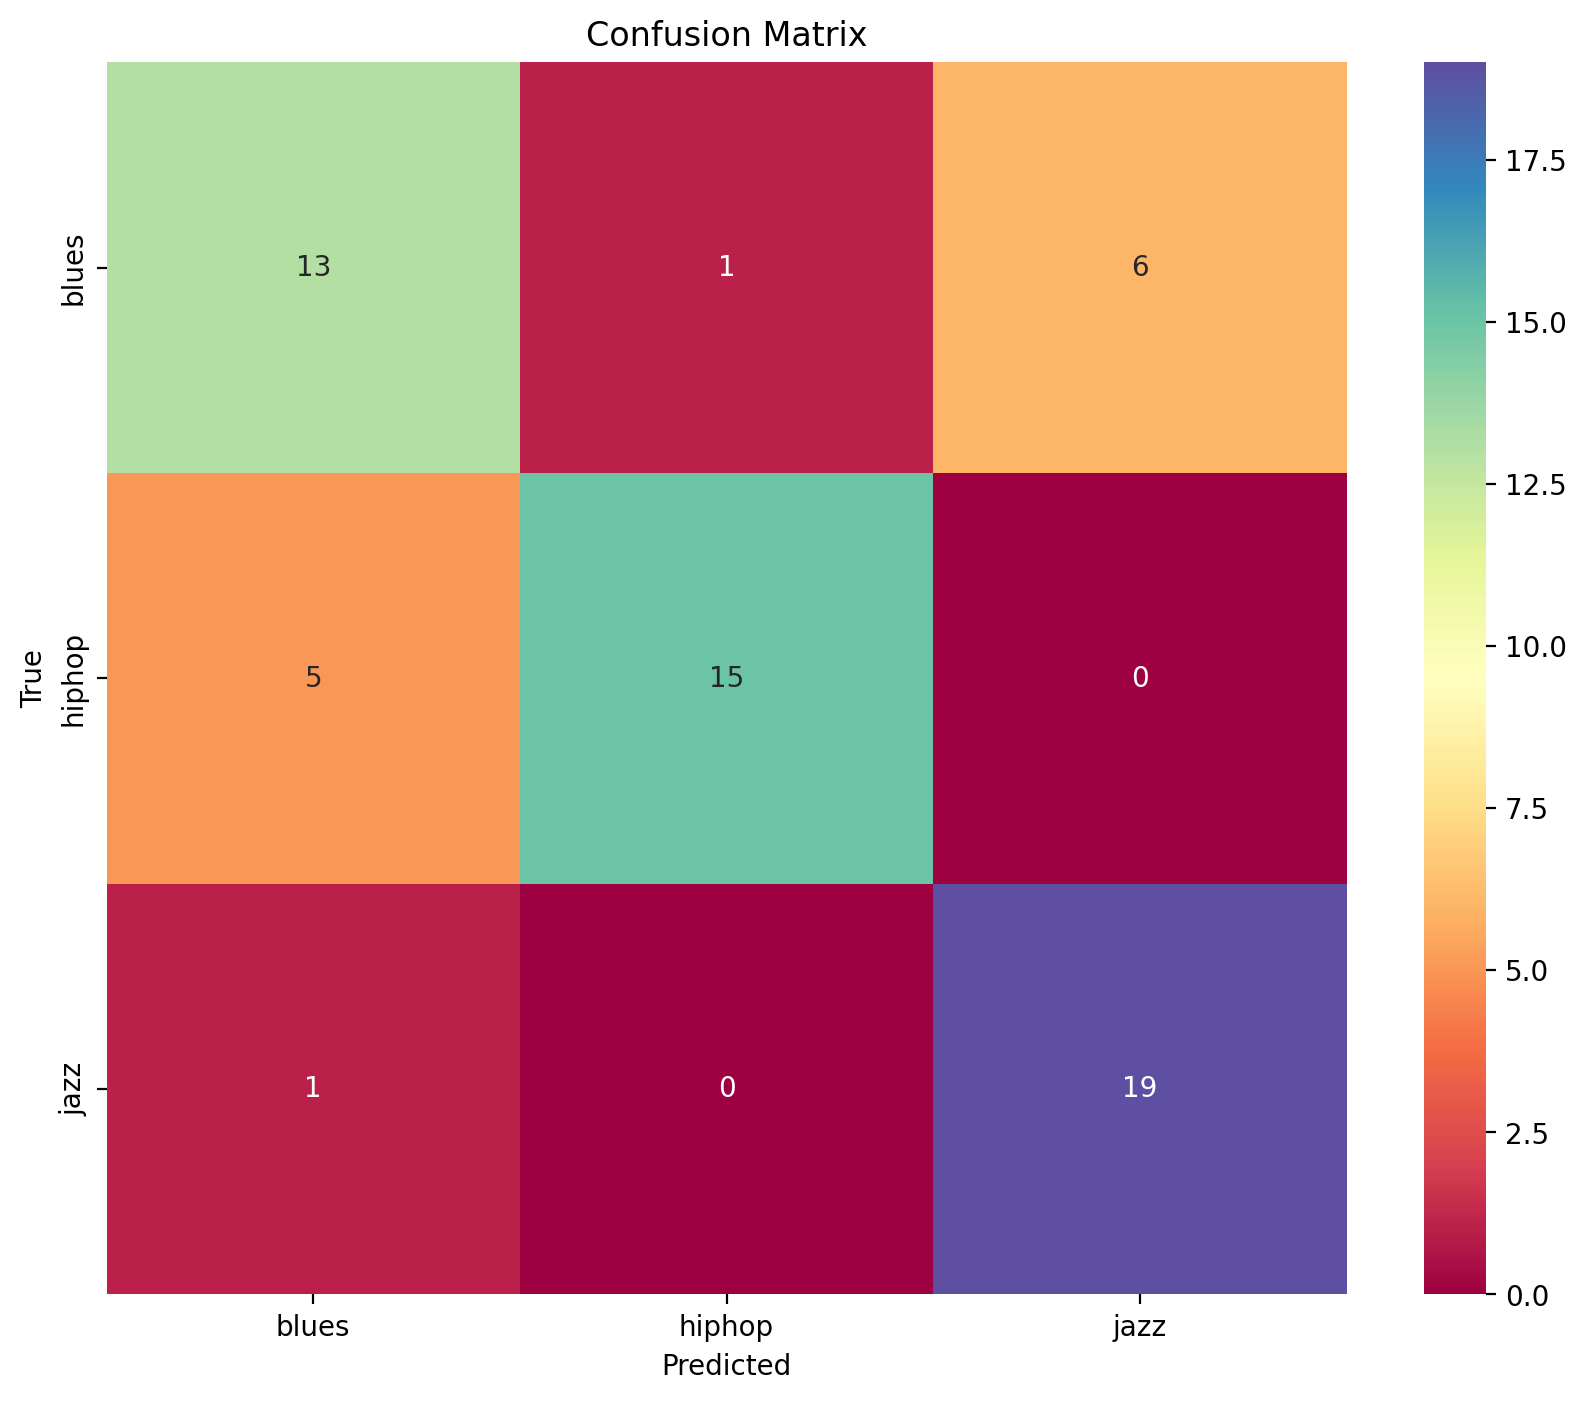

<Figure size 1200x600 with 0 Axes>

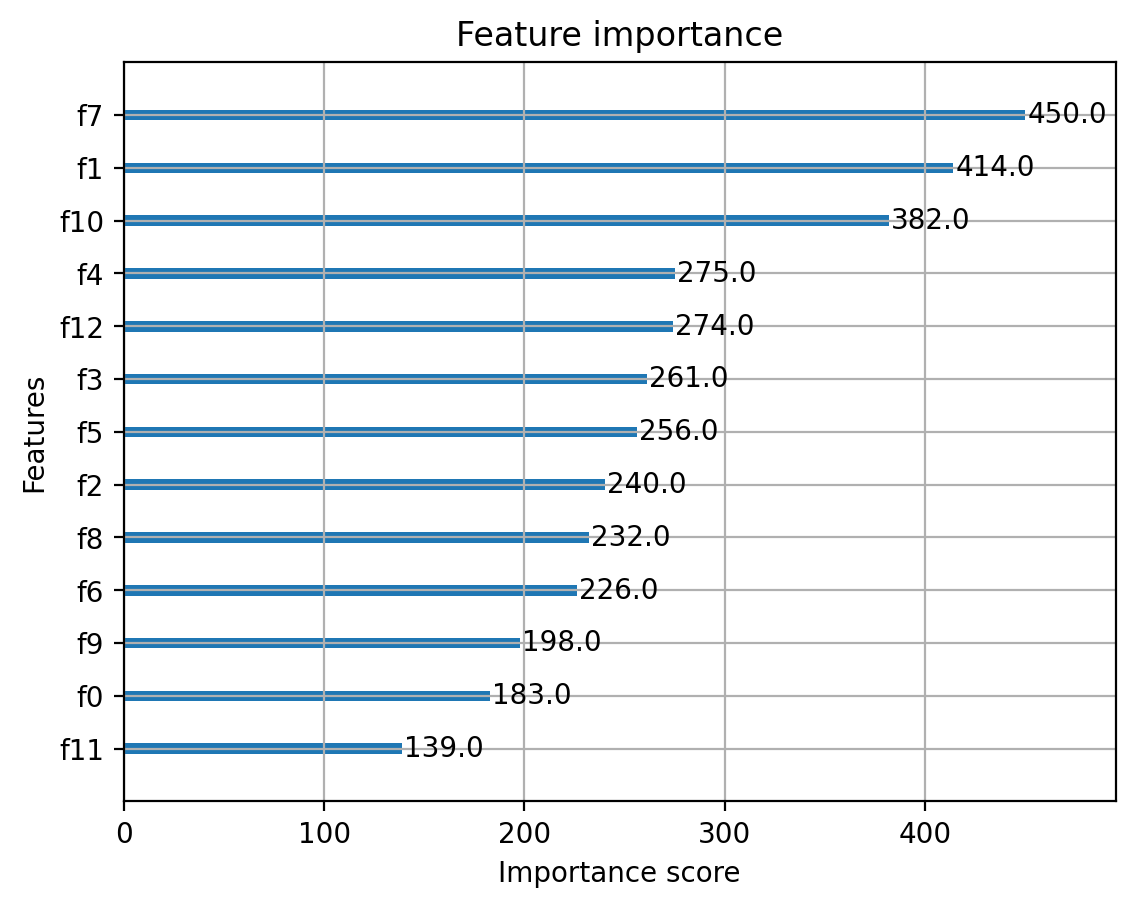

In [52]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=20)
plt.show()

## Genre Tagging from Text Descriptions

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import re

# Sample dataset focused on our three genres
data = {
    'description': [
        "soulful guitar with melancholic vocals and 12-bar structure",
        "smooth saxophone solos with complex chord progressions",
        "boom bap beats with rapped verses and scratching",
        "electric guitar riffs with walking bass lines",
        "improvised solos with swing rhythm",
        "sampled breaks with MC vocals",
        "piano blues with raw emotional delivery",
        "drum machine beats with urban lyrics",
        "call-and-response between trumpet and saxophone",
        "delta-style slide guitar with foot-stomping rhythm"
    ],
    'genre': [
        "blues", "jazz", "hiphop", "blues",
        "jazz", "hiphop", "blues", "hiphop",
        "jazz", "blues"
    ]
}

df = pd.DataFrame(data)

# Text preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Create and train model
genre_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=clean_text,
                             stop_words='english',
                             ngram_range=(1, 2),
                             max_features=500)),
    ('clf', MultinomialNB())
])

genre_classifier.fit(df['description'], df['genre'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500, ngram_range=(1, 2),
                                 preprocessor=<function clean_text at 0x7a2e8fcf8b80>,
                                 stop_words='english')),
                ('clf', MultinomialNB())])

In [54]:
# Focused keyword lists
genre_keywords = {
    "blues": ["guitar", "12-bar", "melancholic", "slide", "delta", "soulful", "harmonica"],
    "hiphop": ["rap", "beats", "mc", "sampled", "urban", "scratch", "boom bap"],
    "jazz": ["saxophone", "improvis", "swing", "trumpet", "chord progress", "solos", "walking bass"]
}

def suggest_genres(description, audio_genre=None):

    # Clean and predict
    cleaned = clean_text(description)
    main_pred = genre_classifier.predict([cleaned])[0]

    # Find supporting evidence
    supporting_genres = []
    for genre, keywords in genre_keywords.items():
        if genre != main_pred:
            if any(keyword in cleaned for keyword in keywords):
                supporting_genres.append(genre)

    if audio_genre:
        if main_pred != audio_genre:
            supporting_genres.append(main_pred)
        return sorted(list(set([audio_genre] + supporting_genres)),
                     key=lambda x: (x != audio_genre, x))

    return [main_pred] + supporting_genres

In [55]:
def classify_music(audio_path=None, description=None):
    results = {}
    if audio_path:
        audio_genre = predict_genre(audio_path)
        results['audio_genre'] = audio_genre
    if description:
        if audio_path:
            text_genres = suggest_genres(description, audio_genre)
            results['combined_genres'] = text_genres
        else:
            text_genres = suggest_genres(description)
            results['text_genres'] = text_genres
    return results

In [56]:
# Text description only
print("Text-only classification:")
print(classify_music(description="a track with smooth saxophone solos and walking bass lines"))

Text-only classification:
{'text_genres': [np.str_('blues'), 'jazz']}


In [57]:
from sklearn.metrics import classification_report

# Generate predictions for evaluation
y_true = df['genre']
y_pred = genre_classifier.predict(df['description'])

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Blues", "Hip-Hop", "Jazz"]))

Classification Report:
              precision    recall  f1-score   support

       Blues       1.00      1.00      1.00         4
     Hip-Hop       1.00      1.00      1.00         3
        Jazz       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

